In [119]:
%load_ext autoreload
%autoreload 2
import RNA
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import calc_MCC, dict_dot_bracket, list_dot_bracket, forna_display, parse_rdat
from penalties import penalize_barriers, get_penalties, penalize_barriers_seq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
shape_data = {}
rdat_files = sorted(['SRP_test/'+f for f in os.listdir('SRP_test') if 'rdat' in f])
#rdat_files = ['SRP_test/'+'SRPECLI_BZCN_0001.rdat.txt']
for r in rdat_files:
    shape_data[r.strip('SRP_test/SRPECLI_').strip('.rdat.txt')] = parse_rdat(r)

# Create dummy data with no constraints
shape_data['kinetic20'] = {}
shape_data['no_constraints'] = {}
for l in shape_data['BZCN_0001']:
    shape_data['kinetic20'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
    shape_data['no_constraints'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
#d = parse_rdat('SRP_test/SRPECLI_BZCN_0001.rdat.txt')
md = RNA.md()
md.temperature = 37

In [4]:
# Calculate folding pathways for each dataset
last_structure = ''
for n, d in shape_data.items():
    print(f'Working on {n}')
    for length in d.keys():
        subseq = d[length]['seq']
        reactivities = d[length]['react']
        # Shape-defined fold
        fc = RNA.fold_compound(subseq, md)
        if n not in ['no_constraints', 'kinetic20']:
            fc.sc_add_SHAPE_deigan(reactivities, 2.6, -0.8)
        if n == 'kinetic20':
            step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : 20
            }
            fc.sc_add_f(penalize_barriers)
            fc.sc_add_data(step_info)
        d[length]['mfe'] = fc.mfe()[0]
        last_structure = d[length]['mfe']


Working on BZCN_0001
Working on BZCN_0002
Working on BZCN_0003
Working on BZCN_0004
Working on DMS_0001
Working on DMS_0002
Working on DMS_0003
Working on kinetic20
Working on no_constraints


In [5]:
# also try drtransformer
print("Working on drtransformer")
shape_data['drtransformer'] = {}
name = 'SRP_drt'
#subprocess.run(['cat', 'SRP_test/SRP.fa', '|', 'DrTransformer' '--name', f'{name}', '--logfile'], shell=True, check=True) # this doesn't work for some reason

with open(f'SRP_test/{name}.log', 'r') as f:
    lines = f.readlines()

last_len = 0
start_len = min(list(shape_data['BZCN_0001'].keys()))
for l in lines:
    l = l.strip()
    if '#' in l:
        continue
    l = l.split()
    curr_len = int(l[0])
    if curr_len < start_len:
        continue
    if curr_len == last_len: # The MFE structure for each length if the first line with that length
        continue
    shape_data['drtransformer'][curr_len] = {
        'seq' : shape_data['BZCN_0001'][curr_len]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][curr_len]['seq']))],
        'mfe' : l[2]
    }
    last_len = curr_len

Working on drtransformer


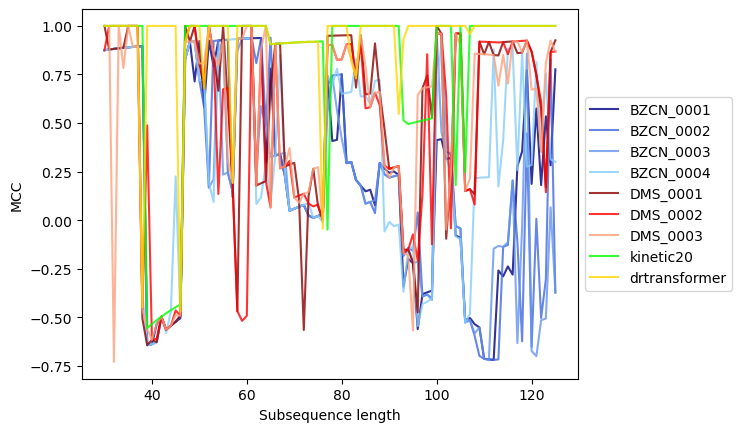

In [6]:
# Plot MCC at each length vs the no_constraints folding
# This at least tells us if if the kinetic method sees the same edges as the SHAPE data predicts
cols = {'BZCN_0001' : 'navy', 
        'BZCN_0002' : 'royalblue', 
        'BZCN_0003' : 'cornflowerblue', 
        'BZCN_0004' : 'lightskyblue', 
        'DMS_0001' : 'darkred', 
        'DMS_0002' : 'red', 
        'DMS_0003' : 'lightsalmon', 
        'kinetic20' : 'lime', 
        'drtransformer' : 'gold',
        'no_constraints' : 'black'}

fig, ax = plt.subplots()
for n, d in [it for it in list(shape_data.items()) if it[0] != 'no_constraints']:
#for n, d in [it for it in list(shape_data.items()) if it[0] != 'BZCN_0003']:
    x = list(d.keys()) # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data['no_constraints'][l]['mfe'])) for l in list(d.keys())]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

ax.set_xlabel('Subsequence length')
ax.set_ylabel('MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

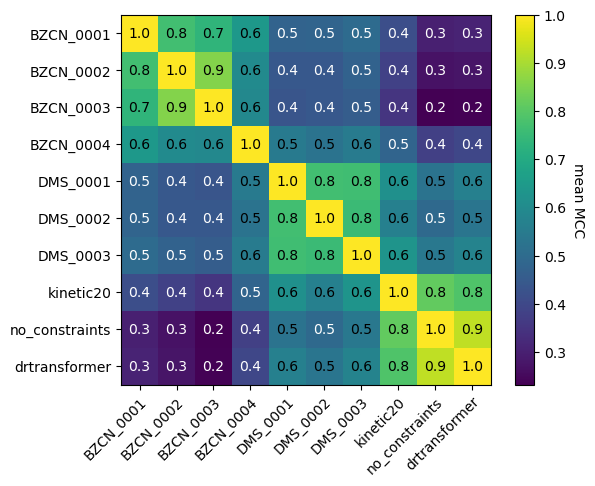

In [7]:
# plot mean MCC between different methods
fig, ax = plt.subplots()
corr = np.ones((len(shape_data.keys()), len(shape_data.keys())))
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(shape_data.items()):
        if i <= j:
            continue
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in list(d1.keys())])
        corr[i, j] = c
        corr[j, i] = c

im = ax.imshow(corr, origin='upper')
ax.set_yticks(np.arange(len(shape_data.keys())), list(shape_data.keys()))
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(corr.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(corr)):
    for j in range(len(corr)):
        kw.update(color=textcolors[int(corr[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(corr[i,j]), **kw)

plt.show()

In [8]:
# Let's try a single-value penalty sweep.  This isn't going to work, but its useful to see.

penalties = np.arange(5, 105, 5)
pred_at_pen = {}
for p in penalties:
    print("working on penalty =", p)
    pred_at_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : int(p)
            }
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)

        pred_at_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_pen[p][length]

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [9]:
penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_pen[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_pen[20].keys())])

In [10]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5	0.435	0.721	0.542
10	0.431	0.714	0.537
15	0.431	0.714	0.537
20	0.449	0.732	0.555
25	0.447	0.718	0.549
30	0.408	0.655	0.500
35	0.394	0.661	0.494
40	0.394	0.661	0.494
45	0.394	0.661	0.494
50	0.397	0.658	0.495
55	0.393	0.647	0.488
60	0.375	0.604	0.461
65	0.440	0.665	0.524
70	0.422	0.652	0.508
75	0.422	0.643	0.505
80	0.399	0.603	0.476
85	0.399	0.603	0.476
90	0.397	0.595	0.471
95	0.397	0.595	0.471
100	0.395	0.580	0.465

Best!
bzcn:	penalty=20 MCC=0.449
dms:	penalty=20 MCC=0.732
all:	penalty=20 MCC=0.555


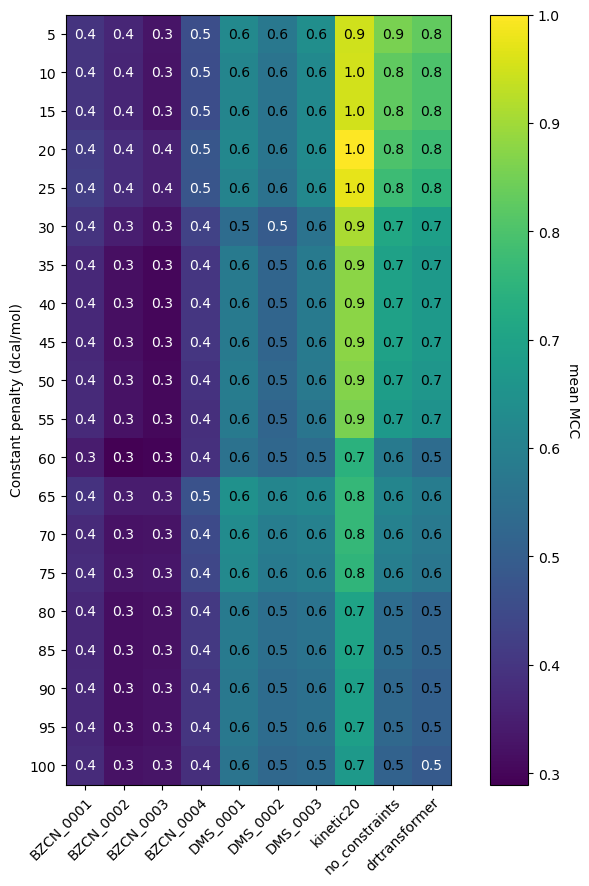

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(penalty_sweep[i, j]), **kw)

plt.show()

In [12]:
# Let's try the situation where it's dependent on the base pair broken

percents = np.arange(0.01, 0.262, 0.012)
pred_at_cent = {}
for p in percents:
    print("Working on percentage = {:.3f}".format(p), end='; ')
    pred_at_cent[p] = {}
    p_list = []
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        if last_structure != '':
            fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
            penalty_dict = get_penalties(last_structure, fc_last)
            p_list.extend([v for v in penalty_dict.values()])
        else:
            penalty_dict = {}
        step_info = {
            'last_dict' : dict_dot_bracket(last_structure),
            'penalty_dict' : penalty_dict,
            'penalty_percent' : p
            }
        fc.sc_add_f(penalize_barriers_seq)
        fc.sc_add_data(step_info)

        pred_at_cent[p][length] = fc.mfe()[0]
        last_structure = pred_at_cent[p][length]
    
    print("mean penalty = {:.0f}".format(np.mean(p_list)*p))

Working on percentage = 0.010; mean penalty = 4
Working on percentage = 0.022; mean penalty = 9
Working on percentage = 0.034; mean penalty = 14
Working on percentage = 0.046; mean penalty = 19
Working on percentage = 0.058; mean penalty = 24
Working on percentage = 0.070; mean penalty = 29
Working on percentage = 0.082; mean penalty = 34
Working on percentage = 0.094; mean penalty = 39
Working on percentage = 0.106; mean penalty = 44
Working on percentage = 0.118; mean penalty = 49
Working on percentage = 0.130; mean penalty = 54
Working on percentage = 0.142; mean penalty = 59
Working on percentage = 0.154; mean penalty = 64
Working on percentage = 0.166; mean penalty = 69
Working on percentage = 0.178; mean penalty = 74
Working on percentage = 0.190; mean penalty = 79
Working on percentage = 0.202; mean penalty = 84
Working on percentage = 0.214; mean penalty = 89
Working on percentage = 0.226; mean penalty = 94
Working on percentage = 0.238; mean penalty = 99
Working on percentage 

In [13]:
cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_cent[0.01].keys())])

In [14]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.435	0.721	0.542
0.022	0.436	0.718	0.542
0.034	0.456	0.734	0.560
0.046	0.456	0.734	0.560
0.058	0.449	0.732	0.555
0.070	0.447	0.718	0.549
0.082	0.443	0.708	0.542
0.094	0.395	0.661	0.494
0.106	0.395	0.661	0.494
0.118	0.397	0.658	0.495
0.130	0.397	0.658	0.495
0.142	0.397	0.658	0.495
0.154	0.375	0.604	0.461
0.166	0.440	0.665	0.524
0.178	0.436	0.662	0.521
0.190	0.436	0.654	0.518
0.202	0.420	0.621	0.495
0.214	0.420	0.621	0.495
0.226	0.420	0.621	0.495
0.238	0.420	0.621	0.495
0.250	0.420	0.613	0.492

Best!
bzcn:	penalty=0.034 MCC=0.456
dms:	penalty=0.034 MCC=0.734
all:	penalty=0.034 MCC=0.560


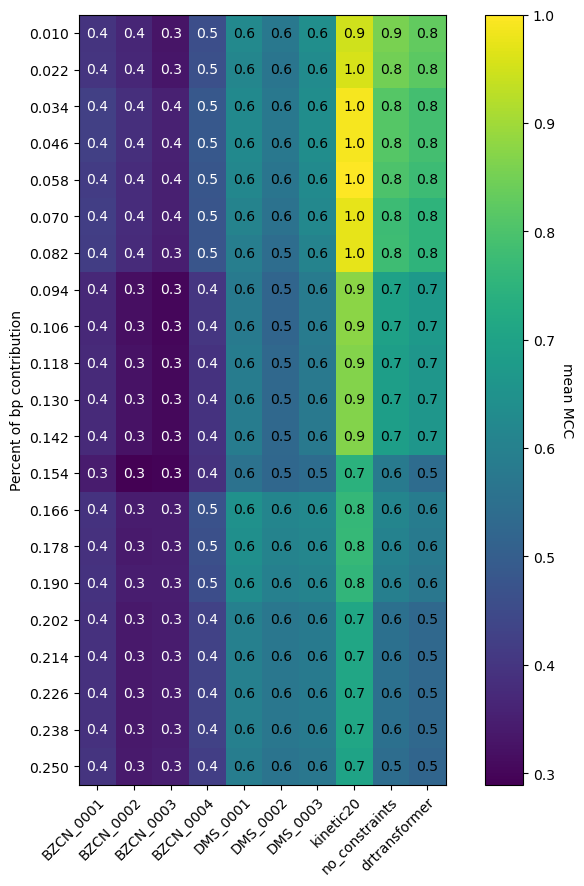

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(cent_sweep[i, j]), **kw)

plt.show()

In [16]:
#p = .5
#last_structure = ''
#for length in shape_data['kinetic20'].keys():
#    subseq = shape_data['kinetic20'][length]['seq']
#    fc = RNA.fold_compound(subseq, md)
#    fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
#    penalty_dict = get_penalties(last_structure, fc_last)
#    step_info = {
#            'last_dict' : dict_dot_bracket(last_structure),
#            'penalty_dict' : penalty_dict,
#            'penalty_percent' : p
#        }
#    fc.sc_add_f(penalize_barriers_seq)
#    fc.sc_add_data(step_info)
#
#    out = fc.mfe()
#
#    last_structure = out[0]
#    print(out)

In [17]:
# Let's see how this compares with hierarchical folding
# The problem here is that I have even less of a 'ground truth' in this case
pred_at_span_pen = {}
full_seq = shape_data['kinetic20'][list(shape_data['kinetic20'].keys())[-1]]['seq']

for p in penalties:
    print("working on penalty =", p)
    pred_at_span_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        mds = RNA.md()
        mds.temperature = 37
        mds.max_bp_span = length
        step_info = {
            'last' : dict_dot_bracket(last_structure),
            'penalty' : int(p)
        }
        fc = RNA.fold_compound(full_seq, mds)
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)
        pred_at_span_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_span_pen[p][length]


working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [127]:
span_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        span_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_span_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_span_pen[5].keys())])

0.875 False
0.8786687791935092 False
0.8819171036881969 False
0.8848133909712856 False
0.8874119674649423 False
0.8401680504168059 False
0.6363636363636364 False
0.6086956521739131 False
0.5833333333333334 False
0.37609021559644396 False
0.26569371377681855 False
0.5364773468565999 False
0.58309518948453 False
0.24056375796867538 False
0.2205891143964442 False
0.23878346647045964 False
0.2553606237816764 False
0.37920242714843616 False
0.3896572546754406 False
0.29731406362757234 False
0.4083098076549404 False
0.24371482196617178 False
0.22652117798996416 False
0.21042233291787654 False
0.13483997249264842 False
0.11973686801784993 False
0.07697617141699876 False
0.13569561401644367 False
0.07961085787020428 False
0.09377194785725053 False
0.08184475910711347 False
0.07055483667322161 False
0.059852398300398804 False
0.07299920121250551 False
0.32008542828758985 False
0.09697187369162884 False
0.41538768779011837 False
0.40134062541999865 False
0.274367876858578 False
0.662096739927977

/Users/erikpoppleton/software/kinetic_folder/utils.py:25: RuntimeWarning: invalid value encountered in scalar divide
  MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))


0.9070929565410569 False
1.0 False
1.0 False
1.0 False
1.0 False
1.0 False
1.0 False
1.0 False
0.9442673704375605 False
0.7135060680126758 False
0.6810052246069989 False
-0.5096471914376256 False
-0.48507125007266594 False
-0.46291004988627577 False
-0.4428074427700477 False
-0.4457893447634325 False
-0.44859602103995444 False
-0.45124262819714017 False
-0.4330127018922193 False
0.4916613370866588 False
0.4459079392444798 False
0.4562184572445113 False
0.46573474706978096 False
0.4745461444737886 False
0.3120158977398046 False
0.29239291514663907 False
0.18470591543243942 False
0.2 False
0.1827956989247312 False
0.16666666666666666 False
0.8379703797669529 False
0.13725490196078433 False
0.15148194186596828 False
0.13801311186847084 False
0.12528246363995119 False
0.11323092464042898 False
0.12646075946565946 False
0.1388738730621637 False
0.003861003861003861 False
0.018717994731537357 False
0.007292691976811835 False
-0.0035540184459011653 False
-0.013865005430425415 False
0.0 False


In [129]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.435	0.721	0.542
0.022	0.436	0.718	0.542
0.034	0.456	0.734	0.560
0.046	0.456	0.734	0.560
0.058	0.449	0.732	0.555
0.070	0.447	0.718	0.549
0.082	0.443	0.708	0.542
0.094	0.395	0.661	0.494
0.106	0.395	0.661	0.494
0.118	0.397	0.658	0.495
0.130	0.397	0.658	0.495
0.142	0.397	0.658	0.495
0.154	0.375	0.604	0.461
0.166	0.440	0.665	0.524
0.178	0.436	0.662	0.521
0.190	0.436	0.654	0.518
0.202	0.420	0.621	0.495
0.214	0.420	0.621	0.495
0.226	0.420	0.621	0.495
0.238	0.420	0.621	0.495
0.250	0.420	0.613	0.492

Best!
bzcn:	penalty=0.034 MCC=0.456
dms:	penalty=0.034 MCC=0.734
all:	penalty=0.034 MCC=0.560


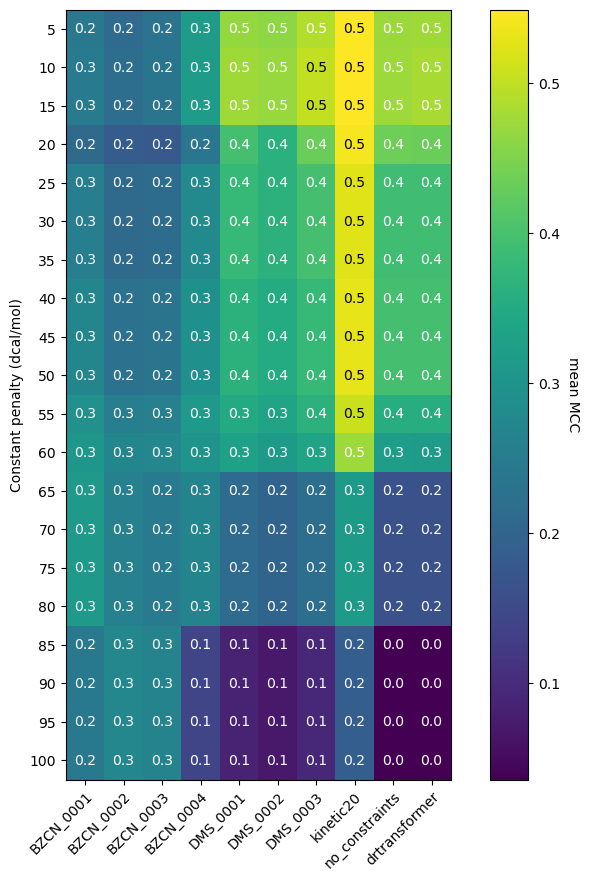

In [130]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(span_penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(span_penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(span_penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(span_penalty_sweep[i, j]), **kw)